In [2]:
%matplotlib inline

In [3]:
import psycopg2
import numpy as np
import pandas as pd
import networkx as nx
import pylab

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:
import modules.community as comm
import modules.community_quality as commq
import modules.helpers as helpers
import matplotlib.pyplot as plt
from scipy import sparse, linalg
from __future__ import division
import urlparse
import clipboard

from scipy.cluster import hierarchy
from scipy.spatial import distance
import numpy, matplotlib

In [5]:
def undirected(df):
    x = []
    y = []
    for i in xrange(len(df)):
        if df['prevMRI_Type'][i] > df['MRI_Type'][i]:
            x.append(df['MRI_Type'][i])
            y.append(df['prevMRI_Type'][i])
        else:
            x.append(df['prevMRI_Type'][i])
            y.append(df['MRI_Type'][i])
    df['x'] = pd.Series(x)
    df['y'] = pd.Series(y)
    
    df = df[['x','y','Weight']]
    df.columns = ['prevMRI_Type','MRI_Type','Weight']
    df = df.groupby(['prevMRI_Type','MRI_Type']).sum().reset_index()
    
    return df

In [6]:
MRI = pd.read_csv("MRI visit in 2 yrs.csv")

In [7]:
MRI.head()

,prevMRI_Type,MRI_Type,MRICnt1,MRICnt2,Cost1,Cost2,Weight
0,MRI Breast,MRI Brain,37,27,25264.78,24214.58,10
1,MRI Upper Area,MRI Head,6,5,3493.24,1485.04,4
2,MRI Chest,MRI Spine,5,7,5405.16,4172.20,3
3,MRI Breast,MRI Abdomen,13,15,9766.14,16730.31,6
4,MRI Head,MRI Lower Area,16,21,8320.25,7701.68,9


In [8]:
MRI[['Weight']] = MRI[['Weight']].astype(int)
MRI_v2 = MRI.sort(['Weight'], ascending=[False]).reset_index()

In [9]:
df = MRI_v2

In [11]:
undirected = undirected(df)

# (A)

In [13]:
set1 = set(undirected['prevMRI_Type'])
set2 = set(undirected['MRI_Type'])
set1 | set2

{'MRI Abdomen',
 'MRI Brain',
 'MRI Breast',
 'MRI Chest',
 'MRI Head',
 'MRI Lower Area',
 'MRI Neck',
 'MRI Pelvis',
 'MRI Spine',
 'MRI Upper Area'}

In [14]:
undirected = undirected.replace(['MRI Abdomen','MRI Brain','MRI Chest','MRI Head','MRI Lower Area','MRI Neck','MRI Pelvis','MRI Spine','MRI Upper Area','MRI Breast'], 
                     [0, 1,2,3,4,5,6,7,8,9])
undirected.head(3)

,prevMRI_Type,MRI_Type,Weight
0,0,1,42
1,0,9,12
2,0,2,6


In [15]:
weighted_edges = []
for i in range(len(undirected)):
    weighted_edges.append((undirected['prevMRI_Type'][i],undirected['MRI_Type'][i], undirected['Weight'][i]))

In [16]:
g5=nx.Graph()

In [17]:
g5.add_nodes_from(range(10))

In [18]:
g5.node[0]['name'] = 'MRI Abdomen'
g5.node[1]['name'] = 'MRI Brain'
g5.node[2]['name'] = 'MRI Chest'
g5.node[3]['name'] = 'MRI Head'
g5.node[4]['name'] = 'MRI Lower Area'
g5.node[5]['name'] = 'MRI Neck'
g5.node[6]['name'] = 'MRI Pelvis'
g5.node[7]['name'] = 'MRI Spine'
g5.node[8]['name'] = 'MRI Upper Area'
g5.node[9]['name'] = 'MRI Breast'

In [19]:
g5.add_weighted_edges_from(weighted_edges)

In [20]:
print g5.number_of_nodes(), g5.number_of_edges()

10 43


In [28]:
def density(graph):
        """ method to calculate the density of a graph """
        g = graph
        V = len(g.keys())
        E = len(self.edges())
        return 2.0 * E / (V *(V - 1))

In [29]:
def highest_centrality(cent_dict):
    #Returns a tuple (node,value) with the node with largest value from Networkx centrality dictionary
    #Create ordered tuple of centrality data
    cent_items=[(b,a) for (a,b) in cent_dict.iteritems()]
    #Sort in descending order
    cent_items.sort()
    cent_items.reverse()
    
    return tuple(reversed(cent_items[0]))

In [30]:
#Measures of centrality

#Nodes that occur on many shortest paths between other nodes in the graph have a high betweenness centrality score.
#The eigenvector centrality of a node proportional to the sum of the centrality scores of its neighbours. A node is important if it connected to other important nodes. A node with a small number of influential contacts may outrank
#one with a larger number of mediocre contacts.

# Betweenness centrality
bet_cen = nx.betweenness_centrality(g5)
# Closeness centrality
clo_cen = nx.closeness_centrality(g5)
# Eigenvector centrality
eig_cen = nx.eigenvector_centrality(g5)

In [31]:
bet_cen

{0: 0.007936507936507936,
 1: 0.007936507936507936,
 2: 0.0,
 3: 0.0,
 4: 0.007936507936507936,
 5: 0.007936507936507936,
 6: 0.007936507936507936,
 7: 0.007936507936507936,
 8: 0.007936507936507936,
 9: 0.0}

In [32]:
print highest_centrality(bet_cen)
print highest_centrality(clo_cen)
print highest_centrality(eig_cen)

(8, 0.007936507936507936)
(8, 1.0)
(7, 0.5294614347980109)


In [36]:
helpers.sample_statistic(g5)

count    10000.000000
mean         0.905515
std          0.096601
min          0.610215
25%          0.822647
50%          0.945161
75%          0.992188
max          1.000000
dtype: float64

In [37]:
#In graph theory, a clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. 
#This measure gives an indication of the clustering in the whole network (global), and can be applied to both undirected and directed networks (often called transitivity.
#The global clustering coefficient is the number of closed triplets (or 3 x triangles) over the total number of triplets (both open and closed).
#The higher, the better.

#Average CC: places more weight on the low degree nodes
#
ccs = nx.clustering(g5)
print sum(ccs)/len(ccs)
print(nx.average_clustering(g5))

4.5
0.961111111111


In [38]:
g5_ccs = sorted(nx.connected_component_subgraphs(g5), key=len, reverse=True)
g5_cc0 = nx.convert_node_labels_to_integers(g5_ccs[0])
pos_g5_cc0 = nx.graphviz_layout(g5_cc0)
pos0_g5_cc0 = nx.spectral_layout(g5_cc0)
g5_cc0.number_of_nodes(), g5_cc0.number_of_edges(), g5_cc0.number_of_selfloops()

(10, 43, 0)

/Users/user/.virtualenvs/data/lib/python2.7/site-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/user/.virtualenvs/data/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/user/.virtualenvs/data/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/user/.virtualenvs/data/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


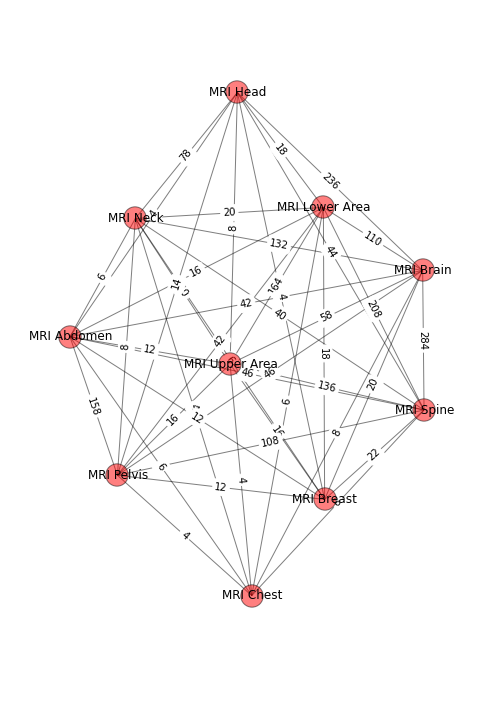

In [39]:
fig, axes = plt.subplots(1, 1, figsize=[8,12])
nx.draw(g5_cc0, pos_g5_cc0, alpha=0.5,node_size=500)
labels1 = nx.draw_networkx_labels(g5_cc0, pos_g5_cc0, labels=nx.get_node_attributes(g5_cc0, 'name'))
elabels1 = nx.draw_networkx_edge_labels(g5_cc0, pos_g5_cc0, nx.get_edge_attributes(g5_cc0, 'weight'))

In [43]:
g5_cc0_clusters, edges_inc_g5_cc0_clusters, edges_mis_g5_cc0_clusters = \
    helpers.prep_clusters(g5_cc0, helpers.skncuts(g5_cc0, max_ncut_size=2, min_ratio=0.06))
print 'number of clusters', len(g5_cc0_clusters)

DONE: num nodes (2) <= 3
DONE: num nodes (1) <= 3
DONE: num nodes (1) <= 3
DONE: num nodes (3) <= 3
DONE: num nodes (3) <= 3
number of clusters 5


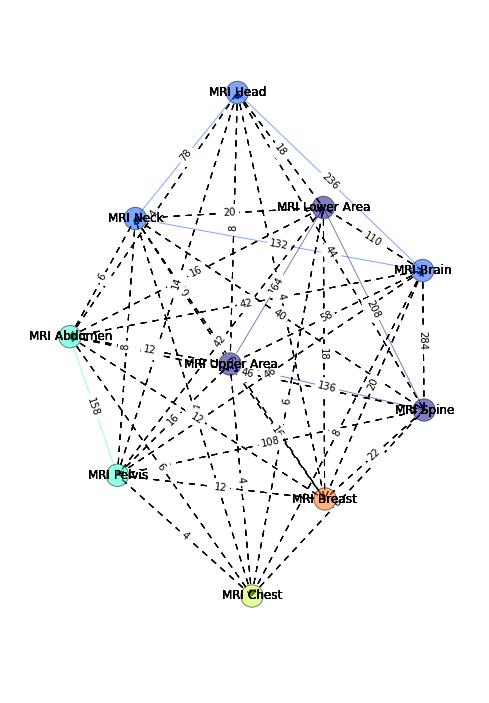

In [44]:
g = g5_cc0
pos = pos_g5_cc0
clusters = g5_cc0_clusters
edges_missing = edges_mis_g5_cc0_clusters
plotter = plt
fig, axes = plotter.subplots(1, 1, figsize=[8, 12])

for h, color in zip(clusters, np.arange(0, 1, 1 / len(clusters))):
    nx.draw(h, pos,
        node_size=500, node_color=[color] * h.number_of_nodes(),
        vmin=0, vmax=1,
        width=1, edge_color=[color] * h.number_of_edges(),
        edge_vmin=0, edge_vmax=1, alpha=0.5)
    nx.draw_networkx_edges(g, pos, width=1, style='dashed',
                           edgelist=edges_missing, edge_color='k',
                           arrows=True)
    nx.draw_networkx_labels(g,pos, labels=nx.get_node_attributes(g5_cc0, 'name'))
    nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g5_cc0, 'weight'))

In [45]:
for i in range(len(g5_cc0_clusters)):
    print 'Cluster',i+1, '=', len(g5_cc0_clusters[i].nodes())

Cluster 1 = 3
Cluster 2 = 3
Cluster 3 = 2
Cluster 4 = 1
Cluster 5 = 1


In [46]:
for i in range(len(g5_cc0_clusters)):
    print 'Cluster',i+1,':'
    for j in g5_cc0_clusters[i].nodes():
        print g5.node[j]['name']
    print '===================='

Cluster 1 :
MRI Upper Area
MRI Lower Area
MRI Spine
Cluster 2 :
MRI Brain
MRI Head
MRI Neck
Cluster 3 :
MRI Abdomen
MRI Pelvis
Cluster 4 :
MRI Chest
Cluster 5 :
MRI Breast


In [47]:
print 'whole graph'
ccs = nx.clustering(g5)
print sum(ccs)/len(ccs)
print(nx.average_clustering(g5))

print '==============='

print 'global clustering coefficient'
clusters =len(g5_cc0_clusters)

for i in range(clusters):
    print sum(nx.clustering(g5_cc0_clusters[i]))/len(nx.clustering(g5_cc0_clusters[i]))

print '==============='

print 'average clustering'
for i in range(clusters):
    print(nx.average_clustering(g5_cc0_clusters[i]))

whole graph
4.5
0.961111111111
global clustering coefficient
6.33333333333
3.0
3.0
2.0
9.0
average clustering
1.0
1.0
0.0
0.0
0.0


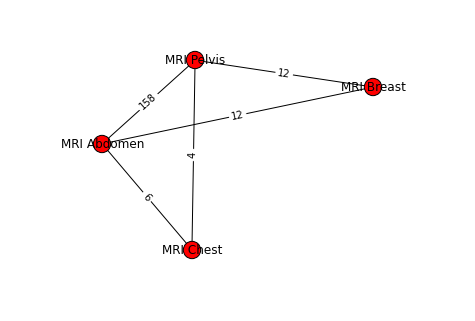

In [116]:
idx = 0
_pos = nx.graphviz_layout(g5_cc0_clusters[idx])
_cc = g5_cc0_clusters[idx]
nx.draw(_cc, _pos)
labels1 = nx.draw_networkx_labels(_cc, _pos, labels=nx.get_node_attributes(_cc, 'name'))
elabels1 = nx.draw_networkx_edge_labels(_cc, _pos, nx.get_edge_attributes(_cc, 'weight'))

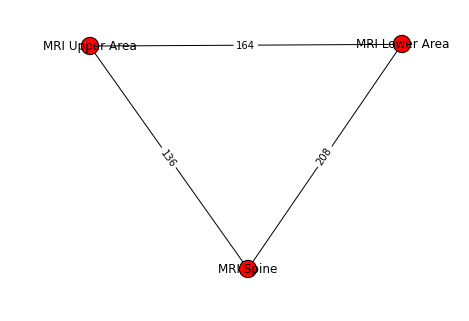

In [117]:
idx = 1
_pos = nx.graphviz_layout(g5_cc0_clusters[idx])
_cc = g5_cc0_clusters[idx]
nx.draw(_cc, _pos)
labels1 = nx.draw_networkx_labels(_cc, _pos, labels=nx.get_node_attributes(_cc, 'name'))
elabels1 = nx.draw_networkx_edge_labels(_cc, _pos, nx.get_edge_attributes(_cc, 'weight'))

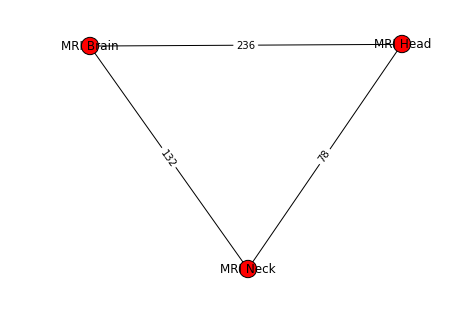

In [118]:
idx = 2
_pos = nx.graphviz_layout(g5_cc0_clusters[idx])
_cc = g5_cc0_clusters[idx]
nx.draw(_cc, _pos)
labels1 = nx.draw_networkx_labels(_cc, _pos, labels=nx.get_node_attributes(_cc, 'name'))
elabels1 = nx.draw_networkx_edge_labels(_cc, _pos, nx.get_edge_attributes(_cc, 'weight'))